In [2]:
# %load analysis.py
#!/usr/bin/python3

########################################
## import packages
########################################
import os
import re
import csv
import logging
import warnings
import requests

import pandas as pd

from operator import itemgetter
from collections import defaultdict

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from gensim.corpora import Dictionary, MmCorpus
from gensim.models import LdaModel, LsiModel, TfidfModel, CoherenceModel

import matplotlib.pyplot as plt
import pyLDAvis.gensim

########################################
## Configurations
########################################

DOCS_DIR = './docs/'
RAILS_DOCS_DIR = DOCS_DIR + 'rails/'
PYTHON_DOCS_DIR = DOCS_DIR + 'python/'
STOP_WORDS = set(stopwords.words('english'))

## Stackoverflow page request parameters
pagesize = 100
site = 'stackoverflow'
key = 'U5pNnFT8KfJCieV9wGb5uQ(('
wordnet_lemmatizer = WordNetLemmatizer()

#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

warnings.filterwarnings('ignore')

%matplotlib inline

########################################
## Support Functions
########################################
def vectorize_docs(lang):
    docs_vector = []
    if lang == 'ruby':
        with open(RAILS_DOCS_DIR+'gettingstarted.txt') as f:
            raw = f.read().replace('\n', '')
            docs_vector.append(raw)
            return docs_vector
    elif lang == 'python':
        python_files = [os.path.join(root, name)
             for root, dirs, files in os.walk(PYTHON_DOCS_DIR)
             for name in files]
        for file in python_files:
            with open(file) as f:
                raw = f.read().replace('\n', ' ')
                docs_vector.append(raw)
        return docs_vector
    else:
        return 0

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def removeSpecialCharacters(documents):
   return [[re.sub('[^A-Za-z0-9]+', '', str(word)) for word in document] for document in documents]

def removeNumbers(documents):
    return [[word for word in document if (len(str(word)) > 2 and not hasNumbers(str(word)))] for document in documents]

def get_stackoverflow_tags():
    if not os.path.isfile('./stackoverflow_tags.csv'):
        has_more = True
        tags = []
        page = 1
        while(has_more):
            request = requests.get('https://api.stackexchange.com/2.2/tags',params={'pagesize' : pagesize,'site' : site, 'page' : page  ,'key' : key}, verify=True, stream=True).json()
            if 'has_more' in request:
                page = page + 1
                for item in request['items']:
                    tags.append(item['name'])
            else:
                has_more = False
        with open('./stackoverflow_tags.csv', 'wb') as outfile:
            writer = csv.writer(outfile,delimiter=';')
            writer.writerow(tags)
    else:
        tags = pd.read_csv('./stackoverflow_tags.csv', header = None, delimiter = ';')
        return tags.values.tolist()
    return tags


def evaluate_graph(dictionary, corpus, texts, limit):
    c_v = []
    lm_list = []
    for num_topics in range(1, limit):
        lm = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, update_every=1, chunksize=100, passes=1)
        lm_list.append(lm)
        cm = CoherenceModel(model=lm, texts=texts, dictionary=dictionary, coherence='c_v')
        c_v.append(cm.get_coherence())

    # Show graph
    x = range(1, limit)
    plt.plot(x, c_v)
    plt.xlabel("num_topics")
    plt.ylabel("Coherence score")
    plt.legend(("c_v"), loc='best')
    plt.show()

    return lm_list, c_v

########################################
## Pre processing
########################################

documents = vectorize_docs('python')

## Stackoverflow tags pre processing
tags = get_stackoverflow_tags()
tags = removeSpecialCharacters(tags)
tags = removeNumbers(tags)
cleared_tags = tags[0]

## Create tokens from documents and check if not in STOP_WORDS
tokenized_docs = []
tokenized_docs = [[word for word in document.lower().split() if word not in STOP_WORDS] for document in documents]

## Remove special characters and numbers
tokenized_docs = removeSpecialCharacters(tokenized_docs)
cleared_docs = removeNumbers(tokenized_docs)

## Lemmatize docs
tokenized_docs = [[wordnet_lemmatizer.lemmatize(word) for word in document] for document in tokenized_docs]

## Remove all words that are not stackoverflow tags
cleared_docs = [[word for word in document if word in cleared_tags] for document in cleared_docs]

## Remove all words that appear only once
frequency = defaultdict(int)

for document in cleared_docs:
    for token in document:
        frequency[token] += 1

cleared_docs = [[token.lower() for token in document if frequency[token] > 1] for document in cleared_docs]

trash_tokens = []

for k, v in sorted(frequency.items(), key=itemgetter(1), reverse=True):
    trash_tokens.append(k)

cleared_tokens = trash_tokens[int(len(trash_tokens) * 0.10) : int(len(trash_tokens) * .90)]

cleared_docs = [[token for token in document if token in cleared_tokens] for document in cleared_docs]

## Save dictionary in serialized form
dictionary = Dictionary(cleared_docs)
dictionary.save('./dictionaries/python_tags.dict')
corpus = [dictionary.doc2bow(document) for document in cleared_docs]
MmCorpus.serialize('./dictionaries/python_tags.mm', corpus)

In [3]:
########################################
## Load Data
########################################
if (os.path.exists("./dictionaries/python_tags.dict")):
    dictionary = Dictionary.load('./dictionaries/python_tags.dict')
    corpus = MmCorpus('./dictionaries/python_tags.mm')
    print("Used dictionary generated")
else:
    print("Please run the preprocessing to generate a dictionary file")

Used dictionary generated


In [4]:
########################################
## Create Model
########################################
print(corpus)
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

MmCorpus(465 documents, 2752 features, 27148 non-zero entries)


In [5]:
########################################
## Applying LSI
########################################
lsi = LsiModel(corpus_tfidf, id2word=dictionary, num_topics=120, decay=1, onepass=False, extra_samples=20)
corpus_lsi = lsi[corpus_tfidf]
print(lsi.show_topics(num_topics=10))
lsitopics = lsi.show_topics(formatted=False)

[(0, '0.096*"subtype" + 0.095*"globals" + 0.089*"finder" + 0.084*"trace" + 0.081*"symbol" + 0.079*"macros" + 0.079*"annotations" + 0.074*"division" + 0.072*"console" + 0.072*"sys"'), (1, '-0.655*"subtype" + -0.408*"payload" + -0.228*"multipart" + -0.210*"contenttype" + -0.155*"macros" + -0.125*"boundary" + -0.123*"double" + -0.116*"unsigned" + -0.114*"layer" + -0.100*"slot"'), (2, '-0.273*"transport" + -0.194*"xmlrpc" + -0.177*"payload" + 0.165*"globals" + 0.154*"clause" + -0.148*"audio" + -0.138*"cgi" + -0.136*"smtp" + -0.129*"tcp" + -0.128*"echo"'), (3, '0.325*"packaging" + -0.249*"audio" + -0.174*"token" + 0.173*"installer" + -0.172*"symbol" + 0.172*"macros" + -0.168*"transport" + 0.151*"building" + -0.146*"clause" + -0.143*"grammar"'), (4, '0.261*"payload" + 0.225*"token" + 0.192*"entity" + 0.184*"sax" + -0.169*"transport" + 0.162*"multipart" + -0.158*"macros" + 0.155*"entities" + 0.153*"symbol" + 0.149*"contenttype"'), (5, '0.615*"audio" + 0.273*"frames" + 0.208*"channels" + -0.20

In [6]:
########################################
## Applying LDA
########################################
lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=120, update_every=1, chunksize=100, passes=1)
print(lda.show_topics(num_topics=10))
ldatopics = lda.show_topics(formatted=False)

[(62, '0.150*"trace" + 0.077*"pdb" + 0.075*"tracing" + 0.061*"statistics" + 0.049*"frozen" + 0.041*"ignore" + 0.036*"overhead" + 0.033*"loaded" + 0.025*"frames" + 0.023*"reload"'), (37, '0.125*"writable" + 0.122*"private" + 0.099*"figure" + 0.068*"maybe" + 0.061*"repeating" + 0.040*"load" + 0.029*"makefile" + 0.025*"crash" + 0.024*"anonymous" + 0.022*"hostname"'), (6, '0.282*"hashlib" + 0.174*"digest" + 0.109*"reduce" + 0.093*"verification" + 0.078*"hmac" + 0.019*"far" + 0.010*"environments" + 0.010*"substring" + 0.008*"lowercase" + 0.007*"cryptography"'), (97, '0.484*"keyerror" + 0.023*"pwd" + 0.012*"shadow" + 0.006*"days" + 0.003*"factory" + 0.002*"account" + 0.002*"country" + 0.001*"privileges" + 0.001*"reserved" + 0.001*"elementtree"'), (29, '0.049*"split" + 0.046*"comments" + 0.045*"ellipsis" + 0.041*"decoding" + 0.035*"append" + 0.034*"opcode" + 0.027*"standards" + 0.026*"any" + 0.025*"extra" + 0.025*"account"'), (87, '0.132*"variations" + 0.097*"minute" + 0.080*"hour" + 0.070*"w

In [7]:
########################################
## Generate Intertopic Distance Map
########################################
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
67     5.855024        1       1  0.139536  0.310638
1      4.300858        1       2  0.123682 -0.006078
73     3.784855        1       3  0.123277  0.170848
107    3.657101        1       4  0.115783  0.211429
104    3.383974        1       5  0.092626 -0.028873
102    3.365378        1       6  0.166387  0.036644
117    2.901602        1       7  0.104267  0.266126
66     2.884021        1       8  0.173497  0.120344
41     2.456098        1       9  0.135013 -0.040911
14     2.183784        1      10  0.104472 -0.021846
84     2.127613        1      11  0.136388  0.014857
29     2.097593        1      12  0.135819  0.184976
58     2.064709        1      13  0.163104 -0.017020
79     2.034298        1      14  0.166302  0.008064
8      1.897166        1      15  0.151182  0.106572
89     1.866773        1      16  0.110745  0.008960
53     1.820725        1      17  0.108920  0.122468
57     1.812289        1      18  0.090975 -0.041873
95     1.810696        1      19  0.134631  0.009627
30     1.661113        1      20  0.113769 -0.053213
115    1.577683        1      21  0.116283  0.034828
62     1.527885        1      22  0.122972 -0.025638
35     1.514517        1      23  0.165664 -0.038351
77     1.441053        1      24  0.118005  0.045553
92     1.384062        1      25  0.107773 -0.052453
60     1.316856        1      26  0.070530  0.211316
88     1.312478        1      27  0.119294 -0.035421
56     1.302204        1      28  0.137838  0.020927
15     1.210081        1      29  0.106024  0.037759
17     1.206044        1      30  0.180476 -0.090422
...         ...      ...     ...       ...       ...
32     0.084536        1      91 -0.147938  0.084117
80     0.026588        1      92 -0.168263  0.001195
22     0.022437        1      93 -0.200928 -0.018883
10     0.006481        1      94 -0.185020 -0.002680
12     0.006481        1      95 -0.189468  0.000825
13     0.006481        1      96 -0.185506  0.002674
21     0.006481        1      97 -0.199643 -0.006060
59     0.006481        1      98 -0.193408 -0.005680
23     0.006481        1      99 -0.199115 -0.005553
25     0.006481        1     100 -0.190438 -0.004690
112    0.006481        1     101 -0.188117  0.001194
111    0.006481        1     102 -0.189779 -0.003439
109    0.006481        1     103 -0.190511 -0.000448
105    0.006481        1     104 -0.191053 -0.001802
96     0.006481        1     105 -0.187151  0.056140
91     0.006481        1     106 -0.171077  0.062095
85     0.006481        1     107 -0.162825  0.045820
83     0.006481        1     108 -0.170609  0.009553
78     0.006481        1     109 -0.198738 -0.006034
74     0.006481        1     110 -0.162595  0.114497
69     0.006481        1     111 -0.172244  0.038064
68     0.006481        1     112 -0.170949  0.004477
65     0.006481        1     113 -0.187263 -0.003042
64     0.006481        1     114 -0.179602  0.009251
63     0.006481        1     115 -0.194960 -0.005875
49     0.006481        1     116 -0.174725  0.070741
38     0.006481        1     117 -0.161325  0.042762
34     0.006481        1     118 -0.166180  0.070658
31     0.006481        1     119 -0.194745 -0.005972
0      0.006481        1     120 -0.169378  0.035391

[120 rows x 5 columns], topic_info=      Category        Freq             Term       Total  loglift  logprob
term                                                                     
117    Default  209.000000          console  209.000000  30.0000  30.0000
666    Default  200.000000           clause  200.000000  29.0000  29.0000
571    Default  164.000000              tar  164.000000  28.0000  28.0000
123    Default  140.000000        converter  140.000000  27.0000  27.0000
958    Default  138.000000             func  138.000000  26.0000  26.0000
48     Default  139.000000              any  139.000000  25.0000  25.0000
13

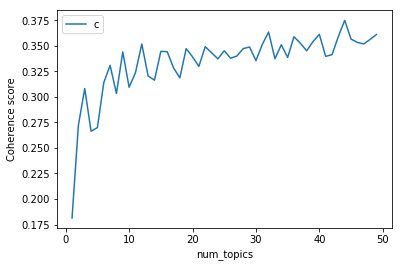

In [10]:
########################################
## Generate Topic Coherence Graph
########################################
lmlist, c_v = evaluate_graph(dictionary=dictionary, corpus=corpus, texts=cleared_docs, limit=50)